In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
%matplotlib inline

In [25]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

In [10]:
def check_point(ax, ay, bx, by, cx, cy):
    bax = bx - ax
    bay = by - ay
    bcx = cx - bx
    bcy = cy - by
    if bax * bcy - bay * bcx <= 0:
        return True
    return False

In [11]:
def check_in_polygon(x1, y1, x2, y2, x3, y3, x4, y4, px, py):
    if check_point(x1, y1, px, py, x2, y2) and check_point(x2, y2, px, py, x3, y3) and \
    check_point(x3, y3, px, py, x4, y4) and check_point(x4, y4, px, py, x1, y1):
        return True
    else:
        return False

In [20]:
def make_new_df(dest, image_to_shape, mask_to_shape):
    train_df = pd.read_csv(
        '/DATA/ichuviliaeva/ocr_data/barcodes/CourseOCRTask3/Train/markup_wo_inverted.csv', 
        encoding = 'utf-16', header=None
    )
    
    orig_files = []
    resized_files, mask_files = [], []
    ws, hs = [], []
    x1_s, y1_s, x2_s, y2_s, x3_s, y3_s, x4_s, y4_s = [], [], [], [], [], [], [], []
    
    for i in tqdm(range(len(train_df))):
        file = train_df.iloc[i][0]
        orig_files.append(file)
        
        x1, y1, x2, y2, x3, y3, x4, y4 = train_df.iloc[i][2:10]
        image = Image.open('/DATA/ichuviliaeva/ocr_data/barcodes/CourseOCRTask3/Train/Images/' + file)
        
        w, h = image.size
        ws.append(w)
        hs.append(h)
        
        image = transforms.Resize((image_to_shape))(image)
        image.save(dest + '/Images/' + file.split('.')[0] + '_resized.png')
        resized_files.append(file.split('.')[0] + '_resized.png')
        
        mask = torch.zeros((1, mask_to_shape[0], mask_to_shape[1]))
        
        x1 = mask_to_shape[0] * x1 / w
        y1 = mask_to_shape[1] * y1 / h
        x2 = mask_to_shape[0] * x2 / w
        y2 = mask_to_shape[1] * y2 / h
        x3 = mask_to_shape[0] * x3 / w
        y3 = mask_to_shape[1] * y3 / h
        x4 = mask_to_shape[0] * x4 / w
        y4 = mask_to_shape[1] * y4 / h
        
        x1_s.append(x1)
        y1_s.append(y1)
        x2_s.append(x2)
        y2_s.append(y2)
        x3_s.append(x3)
        y3_s.append(y3)
        x4_s.append(x4)
        y4_s.append(y4)
        
        for i in range(mask_to_shape[0]):
            for j in range(mask_to_shape[1]):
                if check_in_polygon(y1, x1, y4, x4, y3, x3, y2, x2, i, j):
                    mask[0][i][j] = 1
                else:
                    mask[0][i][j] = 0
        torch.save(mask, dest + '/masks/' + file.split('.')[0] + '_mask.pt')
        mask_files.append(file.split('.')[0] + '_mask.pt')
        
    res_df = pd.DataFrame()
    res_df['original_file'] = orig_files
    res_df['resized_file'] = resized_files
    res_df['mask_file'] = mask_files
    res_df['original_w'] = ws
    res_df['original_h'] = hs
    res_df['x1'] = x1_s
    res_df['y1'] = y1_s
    res_df['x2'] = x2_s
    res_df['y2'] = y2_s
    res_df['x3'] = x3_s
    res_df['y3'] = y3_s
    res_df['x4'] = x4_s
    res_df['y4'] = y4_s
    res_df.to_csv(dest + 'resized_table.csv')
    return res_df

In [21]:
res_df = make_new_df('/DATA/ichuviliaeva/ocr_data/barcodes/resized', (512, 512), (76, 76))

  0%|          | 0/8150 [00:00<?, ?it/s]

In [23]:
display(res_df)

,original_file,resized_file,mask_file,original_w,original_h,x1,y1,x2,y2,x3,y3,x4,y4
0,fc272e4092ccb147a31e66bc1d10fbfb.png,fc272e4092ccb147a31e66bc1d10fbfb_resized.png,fc272e4092ccb147a31e66bc1d10fbfb_mask.pt,2129,901,19.205261,20.918979,56.759042,18.978912,57.008924,55.924528,18.991076,57.021088
1,8cde8cb1b54bca37c9347baf74157d22.png,8cde8cb1b54bca37c9347baf74157d22_resized.png,8cde8cb1b54bca37c9347baf74157d22_mask.pt,496,1724,57.000000,19.088167,55.161290,56.823666,19.000000,57.000000,22.524194,19.000000
2,70a9be0887eae17eabd70c8e607f963f.png,70a9be0887eae17eabd70c8e607f963f_resized.png,70a9be0887eae17eabd70c8e607f963f_mask.pt,1632,917,19.000000,19.062159,57.000000,18.979280,57.000000,57.020720,19.279412,56.606325
3,a029e49dff95a15d2cd396d8f62220c8.png,a029e49dff95a15d2cd396d8f62220c8_resized.png,a029e49dff95a15d2cd396d8f62220c8_mask.pt,1340,596,19.000000,19.000000,57.000000,19.765101,57.000000,55.852349,19.000000,57.000000
4,82ff01909b6d215170dfc26c7be43074.png,82ff01909b6d215170dfc26c7be43074_resized.png,82ff01909b6d215170dfc26c7be43074_mask.pt,1856,949,19.204741,18.979979,56.836207,20.821918,57.000000,57.020021,19.000000,55.738672
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8145,c532771808e76e333ba9e959853886f3.png,c532771808e76e333ba9e959853886f3_resized.png,c532771808e76e333ba9e959853886f3_mask.pt,860,276,7.600000,14.869565,54.967442,14.594203,54.967442,55.623188,7.688372,55.623188
8146,186338ad8f3ff17b6082c023f24563f0.png,186338ad8f3ff17b6082c023f24563f0_resized.png,186338ad8f3ff17b6082c023f24563f0_mask.pt,877,287,9.445838,11.651568,57.541619,14.564460,57.888255,54.550523,9.272520,50.843206
8147,5bac8f6c9bd5e99f92eb396442974c4e.png,5bac8f6c9bd5e99f92eb396442974c4e_resized.png,5bac8f6c9bd5e99f92eb396442974c4e_mask.pt,905,274,10.161326,7.489051,59.120442,3.605839,59.120442,46.598540,10.077348,51.868613
8148,6247db3e424148a859ebf2180f1dcb6f.png,6247db3e424148a859ebf2180f1dcb6f_resized.png,6247db3e424148a859ebf2180f1dcb6f_mask.pt,220,587,54.581818,10.487223,57.000000,67.066440,21.418182,67.454855,19.000000,10.616695


In [37]:
class BarcodeDataset(Dataset):

    def __init__(self, data_path):
        self.data_path = data_path
        self.df = pd.read_csv(data_path + '/resizedresized_table.csv')
        self.image_to_shape = (512, 512)
        self.mask_to_shape = (76, 76)
        
    def __getitem__(self, index):
        file = self.df.iloc[index]['resized_file']
        image = Image.open(self.data_path + '/Images/' + file)
        image = transforms.ToTensor()(image)
        
        mask = torch.load(self.data_path + '/masks/' + self.df.iloc[index]['mask_file'])
        return image, mask
    
    def __len__(self) -> int:
        return len(self.df)

In [44]:
train_dataset = BarcodeDataset('/DATA/ichuviliaeva/ocr_data/barcodes/resized')
train_loader = data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [45]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [46]:
class ZagaynovNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ZagaynovNet, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.net = nn.Sequential(
            nn.Conv2d(in_channels = self.in_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 4),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 8),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 16),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.hidden_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = self.hidden_channels, out_channels = self.out_channels, kernel_size = 3, 
                      padding = 1, stride = 1, dilation = 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)

In [47]:
model = ZagaynovNet(3, 24, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

In [48]:
def train(model, epoch, optimizer, criterion, train_dataloader):
    for e in range(epoch):
        sum_loss = 0
        for image, mask in tqdm(train_dataloader):
            
            image = image.to(device)
            mask = mask.to(device)
            logits = model(image)
            # print('logits.shape = ', logits.shape)
            loss = criterion(logits, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            
        print('epoch {} ended mean loss:{:.3f}'.format(e, sum_loss / len(train_dataloader)))
            

In [49]:
train(model, 10, optimizer, criterion, train_loader)

  0%|          | 0/128 [00:00<?, ?it/s]

epoch 0 ended mean loss:0.442


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 1 ended mean loss:0.207


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 2 ended mean loss:0.165


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 3 ended mean loss:0.152


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 4 ended mean loss:0.144


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 5 ended mean loss:0.135


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 6 ended mean loss:0.128


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 7 ended mean loss:0.126


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 8 ended mean loss:0.120


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 9 ended mean loss:0.118


In [51]:
torch.save(model.state_dict, 'detector_512_epoch_9.pth') 

In [94]:
def train(model, epoch, optimizer, criterion, train_dataloader):
    for e in range(epoch):
        sum_loss = 0
        for image, mask in tqdm(train_dataloader):
            
            image = image.to(device)
            mask = mask.to(device)
            logits = model(image)
            # print('logits.shape = ', logits.shape)
            loss = criterion(logits, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            
        print('epoch {} ended mean loss:{:.3f}'.format(e, sum_loss / len(train_dataloader)))
        if e % 10 == 0:
            torch.save(model.state_dict, 'detector_512_epoch_' + str(e) + '.pth') 
    return model

In [96]:
model = train(model, 70, optimizer, criterion, train_loader)

  0%|          | 0/128 [00:00<?, ?it/s]

epoch 0 ended mean loss:0.116


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 1 ended mean loss:0.112


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 2 ended mean loss:0.111


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 3 ended mean loss:0.110


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 4 ended mean loss:0.108


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 5 ended mean loss:0.107


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 6 ended mean loss:0.105


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 7 ended mean loss:0.104


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 8 ended mean loss:0.102


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 9 ended mean loss:0.101


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 10 ended mean loss:0.101


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 11 ended mean loss:0.100


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 12 ended mean loss:0.100


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 13 ended mean loss:0.099


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 14 ended mean loss:0.099


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 15 ended mean loss:0.098


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 16 ended mean loss:0.097


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 17 ended mean loss:0.098


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 18 ended mean loss:0.097


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 19 ended mean loss:0.097


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 20 ended mean loss:0.096


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 21 ended mean loss:0.096


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 22 ended mean loss:0.095


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 23 ended mean loss:0.095


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 24 ended mean loss:0.094


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 25 ended mean loss:0.094


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 26 ended mean loss:0.093


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 27 ended mean loss:0.093


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 28 ended mean loss:0.093


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 29 ended mean loss:0.093


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 30 ended mean loss:0.093


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 31 ended mean loss:0.092


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 32 ended mean loss:0.091


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 33 ended mean loss:0.091


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 34 ended mean loss:0.091


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 35 ended mean loss:0.091


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 36 ended mean loss:0.090


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 37 ended mean loss:0.090


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 38 ended mean loss:0.091


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 39 ended mean loss:0.090


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 40 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 41 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 42 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 43 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 44 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 45 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 46 ended mean loss:0.088


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 47 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 48 ended mean loss:0.089


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 49 ended mean loss:0.088


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 50 ended mean loss:0.088


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 51 ended mean loss:0.087


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 52 ended mean loss:0.087


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 53 ended mean loss:0.087


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 54 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 55 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 56 ended mean loss:0.087


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 57 ended mean loss:0.087


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 58 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 59 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 60 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 61 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 62 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 63 ended mean loss:0.085


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 64 ended mean loss:0.086


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 65 ended mean loss:0.085


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 66 ended mean loss:0.085


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 67 ended mean loss:0.085


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 68 ended mean loss:0.084


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 69 ended mean loss:0.084


In [99]:
print(model)

ZagaynovNet(
  (net): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (9): ReLU()
    (10): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(4, 4))
    (11): ReLU()
    (12): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(8, 8))
    (13): ReLU()
    (14): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(16, 16))
    (15): ReLU()
    (16): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(24, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [105]:
torch.save(model.state_dict, 'detector_512_epoch_69.pth') 

In [100]:
optimizer2 = optim.Adam(model.parameters(), lr = 0.0001)

In [102]:
def train2(model, epoch, optimizer, criterion, train_dataloader):
    start_e = 70
    for e in range(epoch):
        sum_loss = 0
        for image, mask in tqdm(train_dataloader):
            
            image = image.to(device)
            mask = mask.to(device)
            logits = model(image)
            # print('logits.shape = ', logits.shape)
            loss = criterion(logits, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            
        print('epoch {} ended mean loss:{:.3f}'.format(start_e + e, sum_loss / len(train_dataloader)))
        if epoch % 10 == 0 or e == epoch - 1:
            torch.save(model.state_dict, 'detector_512_epoch_' + str(start_e + e) + '.pth') 
    return model

In [ ]:
model = train2(model, 70, optimizer2, criterion, train_loader)

In [106]:
test_file = os.listdir('/DATA/ichuviliaeva/ocr_data/barcodes/CourseOCRTask3/Test/Images')[0]
print(test_file)

1105913212699e2e8a558191113acbd7.png


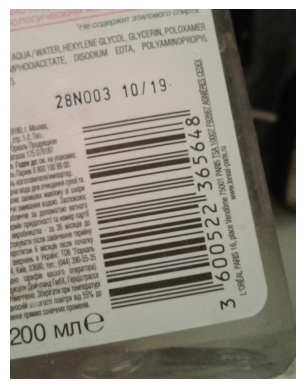

In [163]:
image = Image.open('/DATA/ichuviliaeva/ocr_data/barcodes/CourseOCRTask3/Test/Images/' + test_file)
plt.imshow(image)
plt.axis('off')
plt.show()

In [108]:
w, h = image.size
image = transforms.Resize((512, 512))(image)
image = transforms.ToTensor()(image)

In [112]:
get_mask = model(image.unsqueeze(0).to(device))

In [110]:
import cv2

In [115]:
mask_bool.detach().cpu().numpy() 

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])

In [132]:
mask_bool.detach().cpu().numpy().astype(np.uint8)[0][0].shape

(76, 76)

In [133]:
analysis = cv2.connectedComponentsWithStats(
    mask_bool.detach().cpu().numpy().astype(np.uint8)[0][0], 
    4, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis

In [143]:
max_area = 0
best_comp = -1
for i in range(1, totalLabels):
    area = values[i, cv2.CC_STAT_AREA]  
    if area > max_area:
        max_area = area
        best_comp = i

In [144]:
bestMask = (label_ids == best_comp).astype("uint8") * 255

In [147]:
contours, hierarchy = cv2.findContours(bestMask, 1, 2)

In [151]:
rect = cv2.minAreaRect(contours[0])

In [155]:
print(rect)

((36.676300048828125, 42.39595413208008), (41.28352737426758, 27.674407958984375), 81.25383758544922)


In [153]:
from matplotlib import patches

In [160]:
box = cv2.boxPoints(rect)
box = np.int0(box)
print(box)
image_mask = cv2.drawContours(bestMask,[box],0,(0,0,255),2)

[[19 24]
 [47 19]
 [53 60]
 [26 64]]


<Figure size 700x700 with 0 Axes>

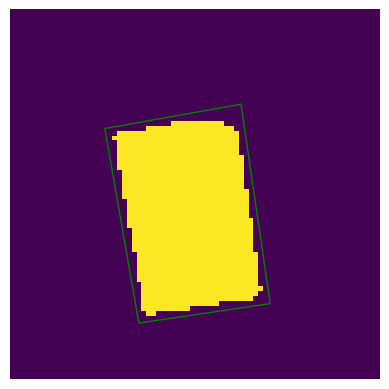

In [162]:
plt.figure(figsize = (7, 7))
fig, ax = plt.subplots()

plt.imshow(image_mask)
plt.axis('off')

p = patches.Polygon(box, edgecolor = 'g', fill=False)
ax.add_patch(p)

plt.show()

In [165]:
image_quad = []
for p in box:
    image_quad.append([w * p[0] / 76, h * p[1] / 76])

<Figure size 700x700 with 0 Axes>

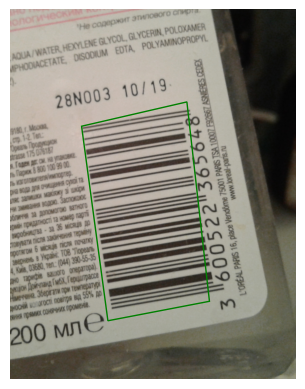

In [166]:
plt.figure(figsize = (7, 7))
fig, ax = plt.subplots()

plt.imshow(image)
plt.axis('off')

p = patches.Polygon(image_quad, edgecolor = 'g', fill=False)
ax.add_patch(p)

plt.show()

In [140]:
print(componentMask.shape)

(76, 76)


In [66]:
mask_bool = 1 * (get_mask > 0.5)
print(mask_bool)

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0')


In [73]:
get_mask.squeeze(0).squeeze(0).shape

torch.Size([76, 76])

In [76]:
points = np.where(get_mask.detach().squeeze(0).squeeze(0).cpu().numpy() > 0.5)

In [87]:
points = np.array(points)
print(points.shape)

(2, 1057)


In [90]:
points_tupled = []
for i in range(points.shape[1]):
    points_tupled.append((points[0, i], points[1, i]))
points_tupled = tuple(points_tupled)

In [91]:
cv2.minAreaRect(points_tupled)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'minAreaRect'
> Overload resolution failed:
>  - points is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'points'


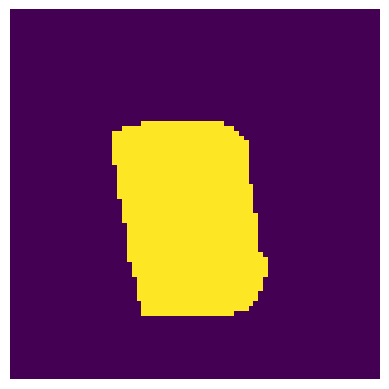

In [67]:
plt.imshow(mask_bool.detach().cpu().numpy().squeeze(0).transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [179]:
class BarcodeTestDataset(Dataset):

    def __init__(self, data_path):
        self.data_path = data_path
        self.files_list = os.listdir(self.data_path + '/Images')
        self.image_to_shape = (512, 512)
        
    def __getitem__(self, index):
        file = self.files_list[index]
        image = Image.open(self.data_path + '/Images/' + file)
        w, h = image.size
        image = transforms.Resize((self.image_to_shape))(image)
        image = transforms.ToTensor()(image)
        return image, w, h, file
    
    def __len__(self) -> int:
        return len(self.files_list)

In [180]:
test_dataset = BarcodeTestDataset('/DATA/ichuviliaeva/ocr_data/barcodes/CourseOCRTask3/Test')
test_loader = data.DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [212]:
ans_x1, ans_y1, ans_x2, ans_y2, ans_x3, ans_y3, ans_x4, ans_y4 = [], [], [], [], [], [], [], []
ans_file = []
def predict(model, test_loader):
    for image, w, h, file in tqdm(test_loader):
        logits = model(image.to(device))
        mask_bool = 1 * (logits > 0.5)
        mask_cpu = mask_bool.detach().cpu().numpy().astype(np.uint8)
        
        for t in range(mask_cpu.shape[0]):
            ans_file.append(file)
            analysis = cv2.connectedComponentsWithStats(mask_cpu[t][0], 4, cv2.CV_32S)
            (totalLabels, label_ids, values, centroid) = analysis
            
            max_area = 0
            best_comp = -1
            for i in range(totalLabels):
                area = values[i, cv2.CC_STAT_AREA]  
                if area > max_area:
                    max_area = area
                    best_comp = i
            
            bestMask = (label_ids == best_comp).astype("uint8") * 255
            contours, hierarchy = cv2.findContours(bestMask, 1, 2)
            rect = cv2.minAreaRect(contours[0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            ans_x1.append(int(box[0][0] * w[t] / 76))
            ans_y1.append(int(box[0][1] * h[t] / 76))
            ans_x2.append(int(box[1][0] * w[t] / 76))
            ans_y2.append(int(box[1][1] * h[t] / 76))
            ans_x3.append(int(box[2][0] * w[t] / 76))
            ans_y3.append(int(box[2][1] * h[t] / 76))
            ans_x4.append(int(box[3][0] * w[t] / 76))
            ans_y4.append(int(box[3][1] * h[t] / 76))

In [213]:
predict(model, test_loader)

  0%|          | 0/7 [00:00<?, ?it/s]

In [214]:
print(ans_x3)

[989, 2791, 1569, 850, 710, 1448, 2310, 1547, 1056, 1470, 1771, 2310, 417, 1411, 1144, 1204, 1138, 1579, 2195, 1613, 1185, 1606, 466, 981, 1725, 1148, 1880, 1997, 2084, 1073, 1179, 978, 789, 1659, 798, 1298, 909, 2567, 2185, 2007, 1695, 530, 1202, 1837, 1681, 2322, 1591, 1829, 1019, 1323, 1676, 530, 2846, 2566, 1792, 1779, 518, 925, 1108, 2192, 1593, 1810, 705, 1327, 930, 1648, 1382, 1122, 1069, 267, 2662, 1749, 1797, 1343, 552, 237, 723, 1265, 2299, 2073, 1128, 1222, 2033, 796, 1746, 1397, 1799, 1608, 739, 1420, 1058, 1393, 1749, 891, 1380, 1826, 1170, 884, 504, 821]


In [217]:
res_df = pd.DataFrame()
res_df[0] = ans_file
res_df[1] = [232323232] * len(ans_file)
res_df[2] = ans_x1
res_df[3] = ans_y1
res_df[4] = ans_x2
res_df[5] = ans_y2
res_df[6] = ans_x3
res_df[7] = ans_y3
res_df[8] = ans_x4
res_df[9] = ans_y4
res_df[10] = [101010101010101010101] * len(ans_file)

In [221]:
res_df.to_csv('answer.csv', encoding = 'utf-16')

In [227]:
!pip install -e .

/bin/bash: /home/ichuviliaeva/miniconda3/envs/ocr_course/lib/python3.8/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/ichuviliaeva/ocr_course/course_ocr/task3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.2 MB/s eta 0:00:0000:0100:01
  Building editable for course_ocr_t3 (pyproject.toml) ... done
  Created wheel for course_ocr_t3: filename=course_ocr_t3-0.1.1-py3-none-any.whl size=1204 sha256=6c85cc03abd93e7db7d009b622d63af54f94a589e3ff38c32c7c2baacaebca23
  Stored in directory: /tmp/pip-ephem-wheel-cache-d5o1rwe1/wheels/ff/0f/62/c58c809f14b9f622c65e7c7a61f5b94a2819377736eeff7828
Successfully built course_ocr_t3

In [228]:
!python3 course_ocr_t3/evaluate.py

/bin/bash: /home/ichuviliaeva/miniconda3/envs/ocr_course/lib/python3.8/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Checking answer (/home/ichuviliaeva/ocr_course/course_ocr/task3/answer.csv) against markup(/home/ichuviliaeva/ocr_course/course_ocr/task3/markup.csv)
Traceback (most recent call last):
  File "course_ocr_t3/evaluate.py", line 62, in <module>
    main()
  File "course_ocr_t3/evaluate.py", line 53, in main
    recognition_accuracy = calculate_accuracy(markup, answer)
  File "course_ocr_t3/evaluate.py", line 36, in calculate_accuracy
    markup_value = markup[k][0]
KeyError: ''
